In [1]:
rm(list= ls())

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(BayesFactor)
library(lme4)
library(lmerTest)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: coda
Loading required package: Matrix

Attaching package: 'Matrix'

The following object is masked from 'package:tidyr':

    expand

************
Welcome to BayesFactor 0.9.12-2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************

Attaching package: 'lmerTest'

The following object is masked from 'package:lme4':

    lmer

The following object is masked from 'package:stats':

    step



In [3]:
data.folder <- 'Experiment 3. Visibility of the illusory Kanizsa triangle'

In [4]:
### loading raw results and computing duration of individual event
results= read.csv(file.path(data.folder, 'Experiment3.csv'), sep=';')


compute.duration <- function(times, events){
    duration <- rep(NA, length(times))
    duration[events==0] <- times[events==1]-times[events==0]
    return(duration)
}

results <- results %>%
    # removing early static masks condition
    filter(RotationSpeed!=0) %>%

    # converting time to seconds
    mutate(Time= Time / 1000) %>%

    # computing duration of disappearances for each target
    group_by(ID, Block, Target) %>%
    mutate(Duration= compute.duration(Time, Event)) %>%

    # making sure that factors as indeed factors
    ungroup() %>%
    mutate(MasksN = factor(MasksN, levels= c(3, 1)))

## Proportion of time participant report that at least one target was invisible

In [5]:
disappearance <- results %>%
    # computing proportion for each block
    group_by(ID, MasksN, Block) %>%
    summarise(time.prop= sum(Duration[Target>0], na.rm= TRUE)/BlockDuration[1]) %>%

    # averaging across blocks for each observer and condition
    group_by(ID, MasksN) %>%
    summarise(time.prop= 100*mean(time.prop))      

disappearance <- data.frame(disappearance)

Looking at the effect of the mask using linear-mixed models and Bayesian ANOVA

In [6]:
lm.null <- lme4::lmer(time.prop ~ 1 + (1|ID), data= disappearance, REML= FALSE)
lm.masks <- update(lm.null, .~. + MasksN)
anova(lm.null, lm.masks)

set.seed(211122017)
sort(anovaBF(time.prop ~ MasksN + ID, data= disappearance, whichRandom = 'ID'))

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,266.4086,270.6121,-130.2043,260.4086,NA,NA,NA
lm.masks,4,266.9454,272.5502,-129.4727,258.9454,1.463175,1,0.2264256


Bayes factor analysis
--------------
[1] MasksN + ID : 0.644225 ±0.69%

Against denominator:
  time.prop ~ ID 
---
Bayes factor type: BFlinearModel, JZS


Plotting

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: time.prop ~ MasksN + (1 | ID)
   Data: disappearance

REML criterion at convergence: 249

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.0196 -0.6747 -0.1354  0.4422  2.6009 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept)  47.91    6.922  
 Residual             306.99   17.521  
Number of obs: 30, groups:  ID, 15

Fixed effects:
            Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)   21.764      4.864 27.499   4.474 0.000121 ***
MasksN1       -7.663      6.398 14.000  -1.198 0.250924    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
        (Intr)
MasksN1 -0.658

Estimate,Std.Error,df,t.value,p.value,R.sqr
21.764056,4.864125,27.49877,4.474403,0.0001206188,0.6490845
-7.662556,6.397793,13.99980,-1.197687,0.2509239810,0.3048601


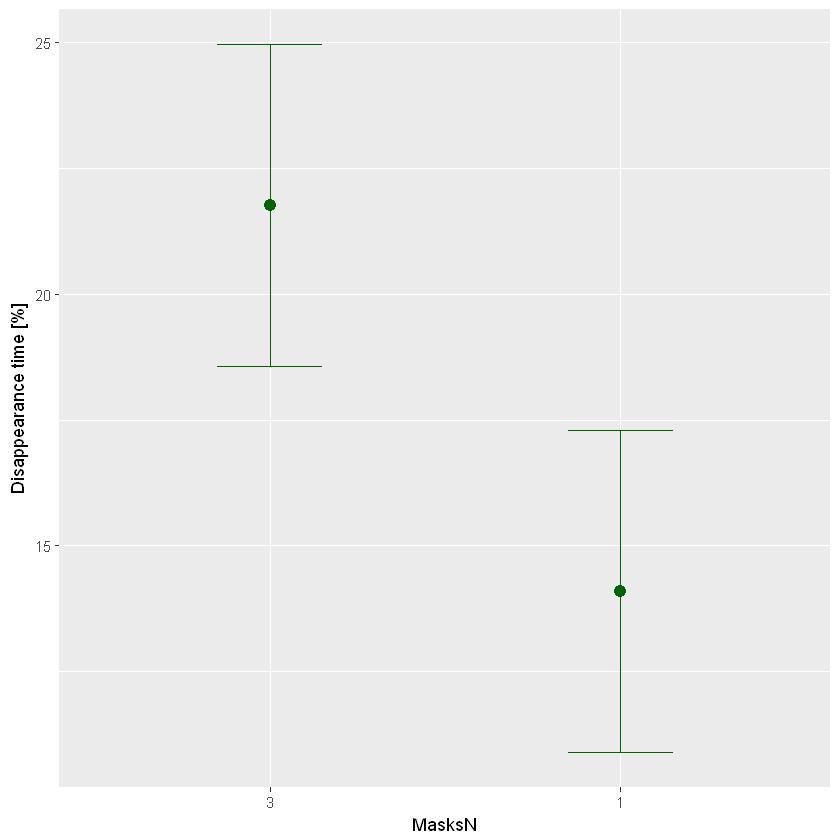

In [7]:
# averages per group
time.per.condition.plot <- disappearance %>%
    # Adjusting observers' means following Loftus & Masson (1994)
    group_by(ID) %>%
    mutate(ID.avg= mean(time.prop)) %>%
    ungroup() %>%
    mutate(overall.avg= mean(time.prop)) %>%
    mutate(time.adjusted= time.prop - ID.avg + overall.avg) %>%

    # computing group averages per condition
    group_by(MasksN) %>%
    summarise(time.avg= mean(time.adjusted),
              time.serr= sd(time.adjusted)/sqrt(n()))


# comparison to the baseline condition (M3)
duration.lmer <- summary(lmerTest::lmer(time.prop ~ MasksN + (1|ID), data= disappearance))
duration.lmer
rcontrast<-function(t, df) {
    return (sqrt(t^2/(t^2 + df)))
}
coefficients.only <- data.frame(duration.lmer$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))


time.plot <- ggplot(data= time.per.condition.plot, aes(x= MasksN, y= time.avg, ymin= time.avg-time.serr, ymax= time.avg+time.serr))+
    geom_errorbar(color= 'darkgreen', width=0.3)+
    geom_point(color= 'darkgreen', size= 3) + 
    ylab('Disappearance time [%]') 
#     ggtitle('Average disappearance time across all targets')
print(time.plot)
ggsave('Figures/Exp3 - Kanitza visibility - disappearance duration.pdf', time.plot, width= 4, height= 5, units = 'cm', useDingbats = FALSE)

## Proportion of time participant report that at the illusory Kanizsa triangle is visible

In [8]:
visibility <- results %>%
    # computing proportion for each block
    group_by(ID, MasksN, Block) %>%
    summarise(time.prop= sum(Duration[Target==0], na.rm= TRUE)/BlockDuration[1]) %>%

    # averaging across blocks for each observer and condition
    group_by(ID, MasksN) %>%
    summarise(time.prop= 100*mean(time.prop))      

visibility <- data.frame(visibility)

Looking at the effect of the mask using linear-mixed models and Bayesian ANOVA

In [9]:
lm.null <- lme4::lmer(time.prop ~ 1 + (1|ID), data= visibility, REML= FALSE)
lm.masks <- update(lm.null, .~. + MasksN)
anova(lm.null, lm.masks)

set.seed(111122017)
sort(anovaBF(time.prop ~ MasksN + ID, data= visibility, whichRandom = 'ID'))

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,290.0583,294.2619,-142.0292,284.0583,NA,NA,NA
lm.masks,4,292.0146,297.6194,-142.0073,284.0146,0.04375087,1,0.8343178


Bayes factor analysis
--------------
[1] MasksN + ID : 0.3455014 ±0.93%

Against denominator:
  time.prop ~ ID 
---
Bayes factor type: BFlinearModel, JZS


Plotting

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: time.prop ~ MasksN + (1 | ID)
   Data: visibility

REML criterion at convergence: 272.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0904 -0.8505  0.1248  0.8483  1.3495 

Random effects:
 Groups   Name        Variance Std.Dev.
 ID       (Intercept)   0       0.00   
 Residual             811      28.48   
Number of obs: 30, groups:  ID, 15

Fixed effects:
            Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)   57.428      7.353 28.002   7.810 1.65e-08 ***
MasksN1        2.102     10.399 28.002   0.202    0.841    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
        (Intr)
MasksN1 -0.707

Estimate,Std.Error,df,t.value,p.value,R.sqr
57.427889,7.353005,28.00231,7.8101251,1.654739e-08,0.82786992
2.102083,10.398719,28.00231,0.2021483,8.412623e-01,0.03817302


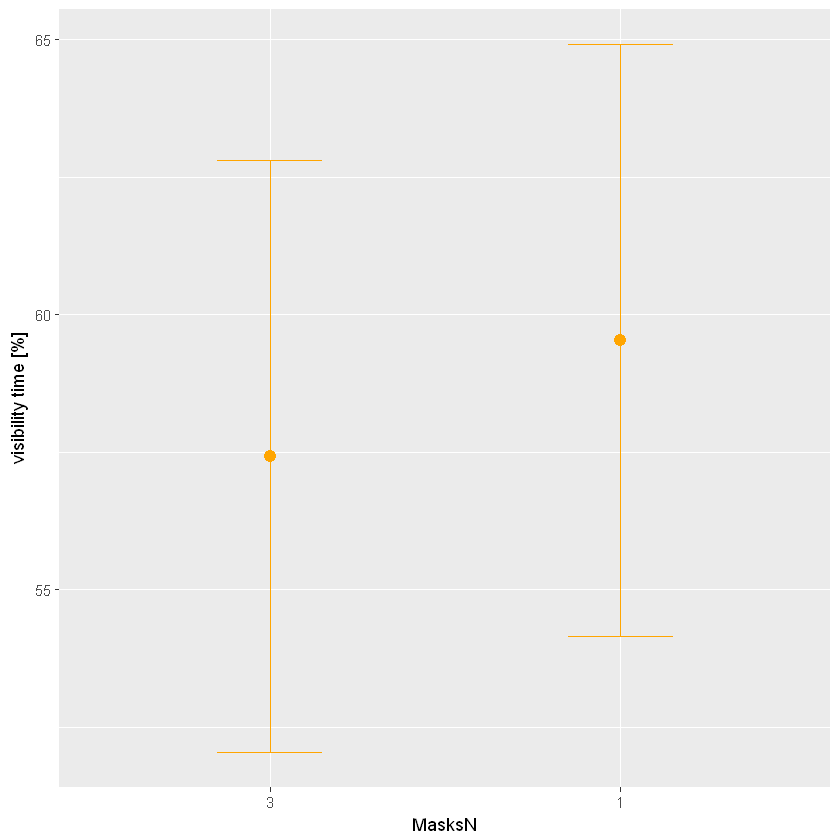

In [10]:
# averages per group
time.per.condition.plot <- visibility %>%
    # Adjusting observers' means following Loftus & Masson (1994)
    group_by(ID) %>%
    mutate(ID.avg= mean(time.prop)) %>%
    ungroup() %>%
    mutate(overall.avg= mean(time.prop)) %>%
    mutate(time.adjusted= time.prop - ID.avg + overall.avg) %>%

    # computing group averages per condition
    group_by(MasksN) %>%
    summarise(time.avg= mean(time.adjusted),
              time.serr= sd(time.adjusted)/sqrt(n()))


# comparison to the baseline condition (M3)
duration.lmer <- summary(lmerTest::lmer(time.prop ~ MasksN + (1|ID), data= visibility))
duration.lmer
rcontrast<-function(t, df) {
    return (sqrt(t^2/(t^2 + df)))
}
coefficients.only <- data.frame(duration.lmer$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))


time.plot <- ggplot(data= time.per.condition.plot, aes(x= MasksN, y= time.avg, ymin= time.avg-time.serr, ymax= time.avg+time.serr))+
    geom_errorbar(color= 'orange', width=0.3)+
    geom_point(color= 'orange', size= 3) + 
    ylab('visibility time [%]') 
#     ggtitle('Average visibility time across all targets')
print(time.plot)
ggsave('Figures/Exp3 - Kanitza visibility - visibility duration.pdf', time.plot, width= 4, height= 5, units = 'cm', useDingbats = FALSE)